### Image Processing for Physicists
#### Pierre Thibault, University of Trieste
##### Exercise 06-1: Median filter and flat field corrections

In this exercise you will explore the use of filters to correct a real X-ray image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import imageio

### Load images
We will work with two frames taken with a scientific CMOS (PCO edge) coupled through a microscope to a thin scintillating material that converts X-rays to visible light.

Load both files, plot them, and check their data type.

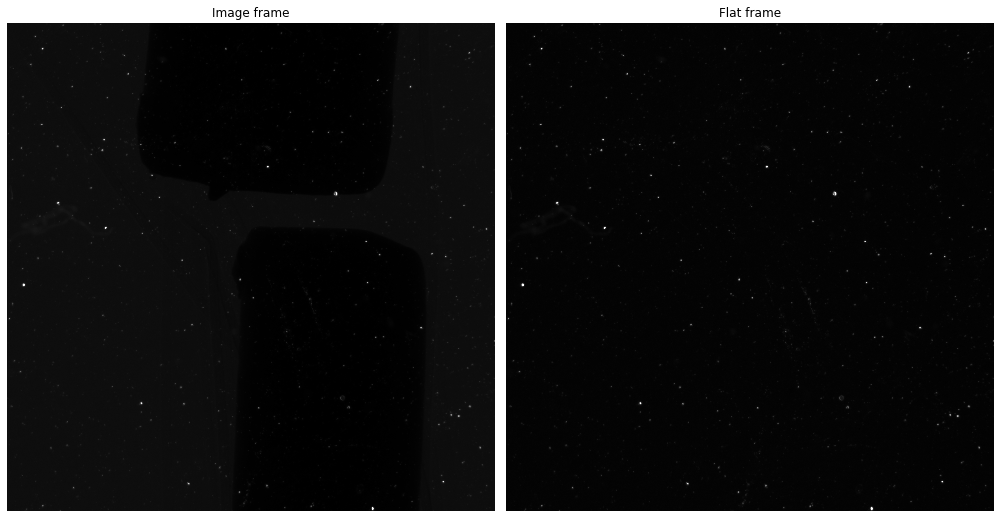

In [92]:
img = imageio.imread('image.tif')
flat = imageio.imread('flat.tif')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[14, 8])
ax1.set_axis_off()
ax1.imshow(img, cmap='gray')
ax1.set_title('Image frame')
ax2.imshow(flat, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Flat frame')

plt.tight_layout()

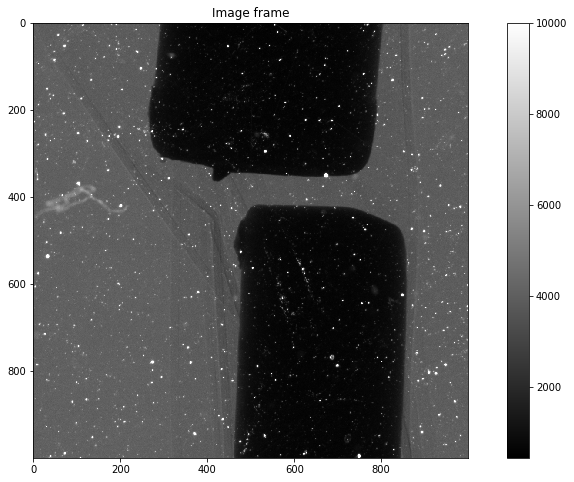

In [93]:
# To see better the image with sample we need to change the range by hand
plt.figure(figsize=[14, 8])
plt.imshow(img, cmap='gray', vmax=10000)
plt.title('Image frame')
plt.colorbar()

### Naive flat field correction
The signal measured by CCD and sCMOS sensors is modified by a (generally adjustable) gain $G$ and offset $O$. Without considering noise, if $S$ is the raw signal (proportional to the incident number of photons) on a pixel, the output $N$ is 

$$N = G S + O.$$

Often, $O$ is chosen to be a small but positive number to ensure that $N$ is always positive (noise can make $S$ negative). Ideally both $G$ and $O$ should be exactly the same for all pixels, but in reality they are not. This is especially true for $G$ if other conversion steps are factored in, as here with the scintillator response.

To recover $S$, we need to know both $G$ and $O$. Here, we will assume $O=100$, which is very close to be true because the level of dark noise is low on this measurement. To find $G$, the trick is to take a measurement where we know that $S$ is constant throughout. Because this involves taking an image of a uniform area, this image is called a "flat field":

$$F = G + O.$$

Now we can isolate $S$:

$$S = \frac{N-O}{F-O}.$$

Let's try this.

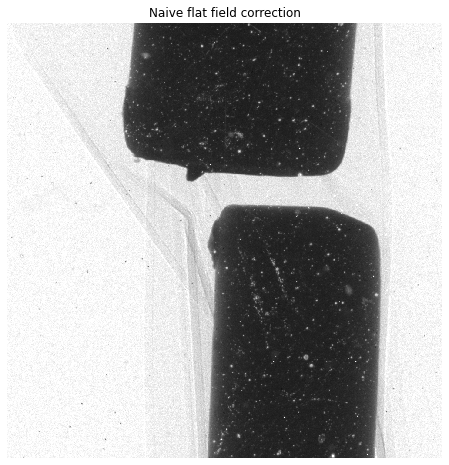

In [94]:
img_corr = (img - 100)/(flat - 100)
fig = plt.figure(figsize=(8,8))
plt.imshow(img_corr, vmin=0, vmax=1., cmap='gray')
plt.axis('off')
plt.title('Naive flat field correction');

The most obvious image degradation is the bright spots scattered throughout. This type of artefact is sometimes caused by "direct hits", i.e. stray X-rays hitting directly the detector sensor and generating very many electrons. Once in a while cosmic rays also cause this. But here, the spots are at the same place in both exposures! They actually come from small imperfections in the scintillator surface: because of total internal reflection, some of the visible light generated by the X-rays travels within the scintillator slab, and is allowed to exit only through these small holes or bumps.
 
These artifacts clearly affect our naive flat field correction. Since they show as isolated "salt & pepper"-like noise, we will try to remove them using a median filter.

Look at the median filter of `scipy.ndimage` and apply it on both images with a window width of 30 pixels.

In [95]:
ndi.median_filter?

In [96]:
f0 = ndi.median_filter(flat, size=30)
i0 = ndi.median_filter(img, size=30)

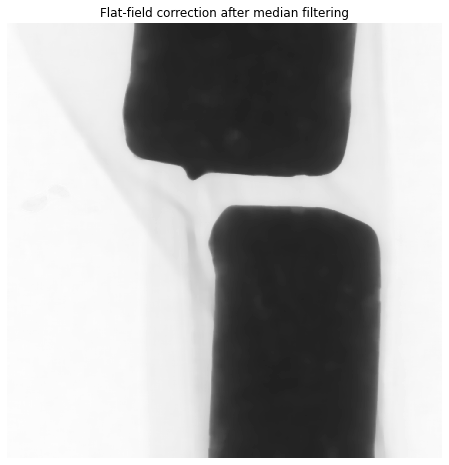

In [98]:
img_corr_medfilt = (i0-100)/(f0-100)
fig = plt.figure(figsize=(8,8))
plt.imshow(img_corr_medfilt, vmin=0, vmax=1., cmap='gray')
plt.axis('off')
plt.title('Flat-field correction after median filtering');

As expected, a median filter of this size has a strong effect on the image. The salt-and-pepper noise is gone, but so are many small details.

We can do better: modify only parts of the images that have been strongly affected by the median filter. We need to decide on a threshold for this. (try 400).

Watch out! The subtraction of two `uint16` arrays is still a `uint16` array, with possible overflows! Better convert the images to `int32` or float for this type of operation 

uint16


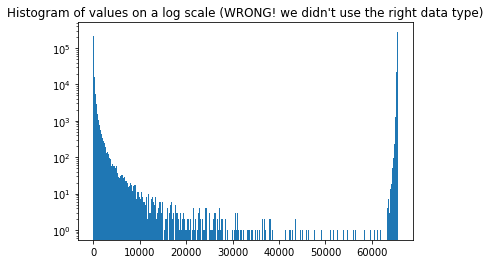

In [100]:
print(img.dtype)
dev = img - i0
plt.figure()
plt.hist(dev.flat, bins=1000)
plt.yscale('log')
plt.title("Histogram of values on a log scale (WRONG! we didn't use the right data type)");

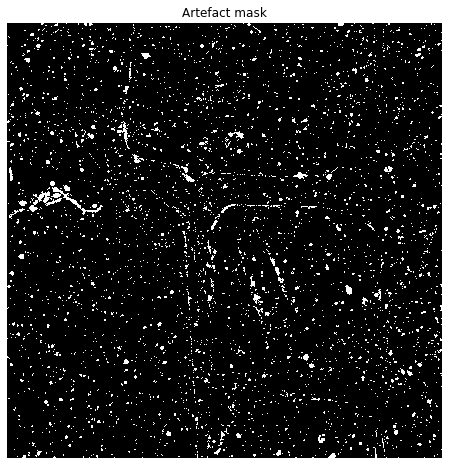

In [69]:
i0 = i0.astype('int')
img = img.astype('int')
mask = abs(i0 - img) > 400
fig = plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Artefact mask');

Why 400? We can take a look at the histogram of the differences between the original image and the filtered one.

In [76]:
dev = img - i0

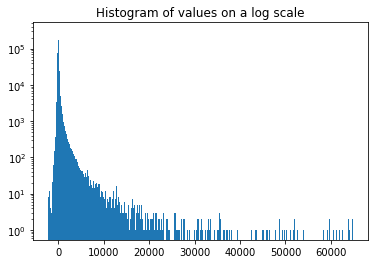

In [77]:
plt.figure()
plt.hist(dev.flat, bins=1000)
plt.yscale('log')
plt.title('Histogram of values on a log scale');

Deciding which are the "outliers" in this case is quite difficult. One way is to look at the width of the deviation distribution and use a multiple of this width as a standard threshold. There are many ways to define "width", but for a statistical distribution, the most common one is the standard deviation:

In [85]:
stdev = np.sqrt(np.var(dev))
print(stdev)

953.5653286704878


But for a long-tailed distribution like this one, the outliers tend to play too large a role. We can use instead the "median absolute deviation" (MAD - https://en.wikipedia.org/wiki/Median_absolute_deviation)

In [86]:
mad = np.median(abs(dev - np.median(dev)))
print(mad)

67.0


For a gaussian distribution, $\sigma \approx 1.5 \times \mathrm{MAD}$. So if we want to have a cutoff at, for instance, $4\sigma$, we use $6 \times \mathrm{MAD}$:

In [87]:
threshold = 6*mad
print(threshold)

402.0


Now let's use this mask to "fill the holes". There are different ways to build an array that combines values from two arrays depending on a binary mask. Here are three:

In [88]:
# Linear combination
def version0():
    img1 = mask*i0 + img*(1-mask)
    return img1

# Alternative: create empty array and fill selectively using mask
def version1():
    img1 = np.zeros_like(img)
    img1[mask] = i0[mask]
    img1[~mask] = img[~mask]
    return img1

# Or, use numpy.where
def version2():
    img1 = np.where(mask, i0, img)
    return img1


In [89]:
# Check that they are all the same
img1_0 = version0()
img1_1 = version1()
img1_2 = version2()

np.allclose(img1_0, img1_1), np.allclose(img1_0, img1_2)

(True, True)

A quick profiling shows that `numpy.where` is the fastest way! Somewhat surprising!

In [90]:
%timeit version0()
%timeit version1()
%timeit version2()

7.74 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.27 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.69 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


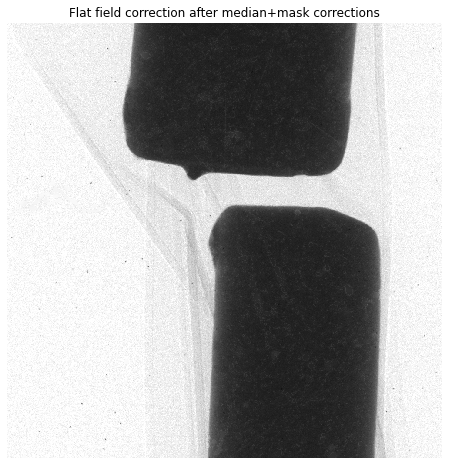

In [91]:
img1 = np.where(mask, i0, img)
flat1 = np.where(mask, f0, flat)
img_corr_medfiltmask = (img1-100)/(flat1-100)
fig = plt.figure(figsize=(8,8))
plt.imshow(img_corr_medfiltmask, vmin=0, vmax=1., cmap='gray')
plt.axis('off')
plt.title('Flat field correction after median+mask corrections');

In our lab, we have been using this approach, combined with a few translations of the sample, to get around this limitation (we are also doing the other obvious thing: looking for better scintillators).